# Import

In [20]:
import torch
from torch import nn
from torch.nn import functional as F
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from collections import  defaultdict

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("DEVICE = ", DEVICE)

from torchsummary import summary

DEVICE =  cuda


# Dataset 

In [21]:
root = os.getcwd()
train_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialNoAnomaly', 'artificialNoAnomaly', 'art_daily_small_noise.csv')
valid_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialWithAnomaly', 'artificialWithAnomaly', 'art_daily_jumpsdown.csv')
test_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialWithAnomaly', 'artificialWithAnomaly', 'art_daily_jumpsup.csv')

assert os.path.exists(train_dataset_path), f"Path to train dataset {train_dataset_path} not found"
assert os.path.exists(valid_dataset_path), f"Path to valid dataset {valid_dataset_path} not found"
assert os.path.exists(test_dataset_path), f"Path to test dataset {test_dataset_path} not found"

# Prepare train, valid, and test datasets

In [22]:
train_df = pd.read_csv(train_dataset_path)
valid_df = pd.read_csv(valid_dataset_path)
test_df = pd.read_csv(test_dataset_path)
print('train df = ', train_df.shape)
print('valid df = ', valid_df.shape)
print('test df = ', test_df.shape)
train_df['timestamp'] = train_df.timestamp.astype("datetime64[ns]")
valid_df['timestamp'] = valid_df.timestamp.astype("datetime64[ns]")
test_df['timestamp'] = test_df.timestamp.astype("datetime64[ns]")
train_df.head()

train df =  (4032, 2)
valid df =  (4032, 2)
test df =  (4032, 2)


,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120


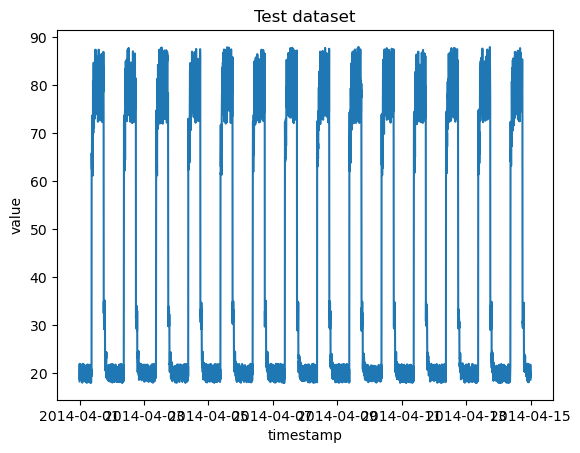

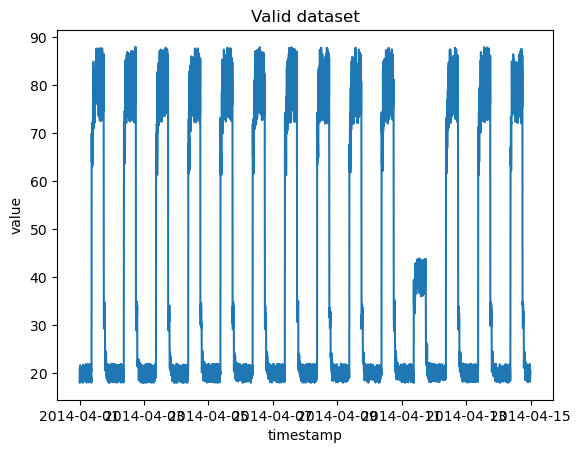

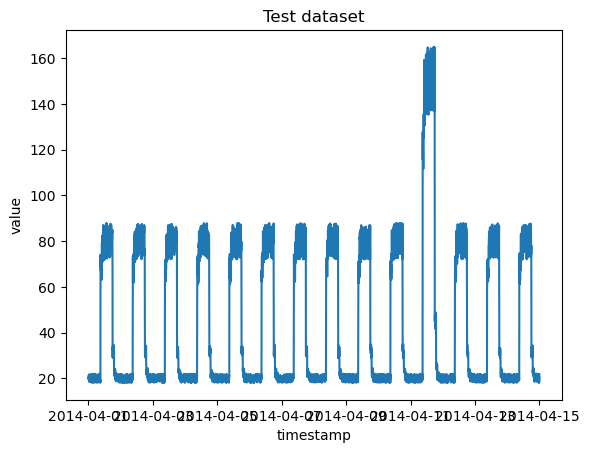

In [23]:
sns.lineplot(y = train_df['value'], x = train_df['timestamp'])
plt.title("Test dataset")
plt.show()
sns.lineplot(y = valid_df['value'], x = valid_df['timestamp'])
plt.title("Valid dataset")
plt.show()
sns.lineplot(y = test_df['value'], x = test_df['timestamp'])
plt.title("Test dataset")
plt.show()

# Make Sequence

In [24]:
def normalize(df):
    df = (df - df.min())/(df.std())
    return df

def normalize_std(df):
    df = (df - df.mean())/(df.std())
    return df

def make_sequence(df, col, scaler,  time_step = 200, debug = False):
    #make sure to normalize columns

    array = []
    values = scaler.transform(df[col].values.reshape(-1,1))
    values = values.reshape(-1)

    for i in range(len(values) - time_step + 1):
        array.append(values[i: i + time_step])

    array = np.stack(array)
    if debug:
        print(f'array mean = {np.mean(array)}, max = {np.max(array)}, min = {np.min(array)}, std = {np.std(array)}')
    
    return torch.tensor(array)


# scaler = MinMaxScaler()
# test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

# X_train = make_sequence(train_df, 'value', scaler = scaler, debug = True)
# X_valid = make_sequence(valid_df, 'value', scaler = scaler, debug = True)
# X_test = make_sequence(test_df, 'value',   scaler = scaler, debug = True)
# print('X train = ', X_train.shape)
# print('X valid = ', X_valid.shape)
# print('X test = ', X_test.shape)


# LSTM model

In [25]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, 
        encoder_num_layers = 2, decoder_num_layers = 2,
        dropout = 0.2, batch_first = True) -> None:
        super().__init__()

        self.encoder = nn.LSTM(
            1, 
            hidden_size, 
            num_layers = encoder_num_layers,
            dropout = dropout,
            batch_first = batch_first, 
            )
        
        self.decoder = nn.LSTM(
            1,
            input_size,
            num_layers = decoder_num_layers,
            batch_first = batch_first,
            dropout = dropout
        )

        self.fc = nn.Linear(input_size * hidden_size, input_size)

    
    def forward(self, X):
        X = X.unsqueeze(-1)

        enc_out, (enc_hidden, enc_state) = self.encoder(X)
        decoder_input = enc_hidden[-1].unsqueeze(-1)

        dec_out, (dec_hidden, dec_state) = self.decoder(decoder_input)
        linear_input = torch.flatten(dec_out, start_dim=1)
        output = self.fc(linear_input)
        # print('enc hidden = ', enc_hidden.shape)
        # print('dec output = ', dec_out.shape)
        # print('linear input = ', linear_input.shape)
        # print('outptu shape = ', output.shape)
        return F.relu(output)


In [40]:
sample = torch.rand(200,10)
ae =Autoencoder(100, 10).to(DEVICE)



TypeError: rand(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 2

In [ ]:
class AutoencoderV2(nn.Module):
    def __init__(self, input_size, hidden_size, 
        encoder_num_layers = 2, decoder_num_layers = 2,
        dropout = 0.2, batch_first = True) -> None:
        super().__init__()

        self.encoder = nn.LSTM(
            1, 
            hidden_size, 
            num_layers = encoder_num_layers,
            dropout = dropout,
            batch_first = batch_first, 
            )
        
        # self.decoder = nn.LSTM(
        #     1,
        #     input_size,
        #     num_layers = decoder_num_layers,
        #     batch_first = batch_first,
        #     dropout = dropout
        # )

        decoder_input_size = encoder_num_layers * hidden_size

        self.decoder = nn.Sequential(
            nn.LazyLinear(decoder_input_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(input_size),
            nn.ReLU()
        )

        # self.fc = nn.Linear(input_size * hidden_size, input_size)

    
    def forward(self, X):
        X = X.unsqueeze(-1)

        enc_out, (enc_hidden, enc_state) = self.encoder(X)
        enc_hidden = torch.transpose(enc_hidden, 1, 0)
        decoder_input = torch.flatten(enc_hidden, start_dim = 1)

        output = self.decoder(decoder_input)
        # print('enc hidden = ', enc_hidden.shape)
        # print('dec output = ', dec_out.shape)
        # print('linear input = ', linear_input.shape)
        # print('outptu shape = ', output.shape)
        return F.relu(output)

In [ ]:
sample = torch.rand(200,10)
ae =Autoencoder(10, 5)

output = ae(sample)
print('ae outut = ', output.shape)

ae outut =  torch.Size([200, 10])


In [ ]:
# Test the autoencoder
sample = torch.rand(200,10,1)

print(sample.shape)
encoder = nn.LSTM(1, 3, 2, batch_first = True)
o,(h,s) = encoder(sample)
print('output shape = ', o.shape)
print('hidden shape = ', h.shape)
print('state shape = ', s.shape)

# h = torch.transpose(h, 1,0)
# decoder_input = torch.transpose(h, 1,0)
decoder_input = h[-1].unsqueeze(-1)


print('decoder')
print('decoder input = ', decoder_input.shape)
decoder = nn.LSTM(1, 10, 2, batch_first = True)
o,(h,s) = decoder(decoder_input) 
print('output shape = ', o.shape)
print('hidden shape = ', h.shape)
print('state shape = ', s.shape)

linear_input = torch.flatten(o, start_dim = 1)
print('linear input shape = ', linear_input.shape)
fc = nn.Linear(30,10)
o = fc(linear_input)
print('linear')
print('output shape = ', o.shape)


# ae =Autoencoder(10, 1)

# output = ae(sample)
# print('ae outut = ', output.shape)

torch.Size([200, 10, 1])
output shape =  torch.Size([200, 10, 3])
hidden shape =  torch.Size([2, 200, 3])
state shape =  torch.Size([2, 200, 3])
decoder
decoder input =  torch.Size([200, 3, 1])
output shape =  torch.Size([200, 3, 10])
hidden shape =  torch.Size([2, 200, 10])
state shape =  torch.Size([2, 200, 10])
linear input shape =  torch.Size([200, 30])
linear
output shape =  torch.Size([200, 10])


In [ ]:
def tune(model, X_train, optimizer, criterion, epochs = 1000):

    loop = tqdm(range(epochs))
    history = defaultdict(list)
    for e in loop:
        model.train()

        X_pred = model(X_train)

        loss = criterion(X_pred, X_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history['train loss'].append(loss.item())

        loop.set_description(f'e = {e}, train loss = {loss.item():.3f}')

    return model, history

def plot(history):
    indices = list(range(len(history['train loss'])))
    sns.lineplot(y = history['train loss'], x =indices, label = 'train')
    plt.title("Train Loss")
    plt.show()

# Set Threshold
### Question
- why do we use MAE over MSE while choosing threshold? 

In [27]:
def get_threshold(autoencoder, X, plot = False, percentile = 100):
    # Use maximum reconstruction error of train data as threshold 
    # X_train = make_sequence(df, 'value', time_step=timestep)
    train_reconstruction = autoencoder(X.float())

    mae_loss = get_mae(X, train_reconstruction)
    mae_loss = mae_loss.squeeze(0).detach().cpu().numpy()

    if plot:
        plot_reconstruction_error_dist(mae_loss)

    threshold = np.percentile(mae_loss, percentile)
    return threshold

def plot_reconstruction_error_dist(mae_loss_array):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(mae_loss_array, bins=50, density=True, label="clean", alpha=.6, color="green")
    plt.title('reconstruction  loss histogram')
    plt.show()

def plot_reconstruction(autoencoder, df, timestep, scaler, device = DEVICE):
    real_values = scaler.transform(df['value'].values.reshape(-1,1)).reshape(-1)
    X = make_sequence(df, 'value', time_step=timestep, scaler = scaler ).to(device)
    reconstruction = autoencoder(X.float())

    reconstruction = reconstruction[:,1].detach().cpu().numpy()
    indices = list(range(len(reconstruction)))
    sns.lineplot(y = real_values, x = df['value'].index)
    plt.title("Test dataset")
    sns.lineplot(y = reconstruction, x = indices, label = 'reconstruction', color = 'red')
    plt.title('reconstruction')
    plt.show()

def get_mae(input, target):
    return torch.mean(torch.abs(target - input), dim = 1)



# Detect anomaly

In [112]:
def detect_anomaly(autoencoder, df, timestep, scaler, threshold, device= DEVICE):
    # timestep = 300
    X_valid = make_sequence(df, 'value', time_step= timestep, scaler = scaler).to(device)

    valid_reconstruction = autoencoder(X_valid.float())

    mae_loss = get_mae(X_valid, valid_reconstruction)
    print('mae loss = ', mae_loss)

    anomaly_indices = (mae_loss > threshold).detach().cpu().numpy()
    valid_reconstruction = valid_reconstruction.detach().cpu().numpy()
    X_valid = X_valid.detach().cpu().numpy()

    anomaly_df = df[:df.shape[0] - timestep + 1].iloc[anomaly_indices]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
    sns.lineplot(y = valid_reconstruction[100], x = list(range(timestep)), label = 'reconstruction', color = 'red', ax = ax1)
    sns.lineplot(y = X_valid[100], x = list(range(timestep)), label = 'target', ax = ax1)
    ax1.set_title('Reconstruction per instance')
    sns.lineplot(y = df['value'], x = df.index, label = 'target', ax = ax2)
    sns.lineplot(y = anomaly_df['value'], x = anomaly_df.index, label = 'anomaly', color = 'red', ax = ax2)
    ax2.set_title(f'Abnormal with threshold={threshold}')
    plt.show()





# Exp 1

In [28]:
EMBEDDING_SIZE = 10
LR = 1e-3
TIME_STEP = 300
EXPERIMENT_NAME = 'v1'

tmp_df = train_df.copy() 
scaler = MinMaxScaler()
test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

X_train = make_sequence(train_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_valid = make_sequence(valid_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_test = make_sequence(test_df, 'value',   time_step= TIME_STEP, scaler = scaler, debug = True)

X_train = X_train.float().to(DEVICE)
# X_valid = X_valid.float().to(DEVICE)
# X_test = X_test.float().to(DEVICE)

print(X_train.shape)



autoencoder = Autoencoder(input_size = TIME_STEP, hidden_size= EMBEDDING_SIZE, dropout = 0.2)

autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
autoencoder, history = tune(autoencoder, X_train, optimizer, criterion, epochs = 1000)

plot(history)

torch.save(autoencoder, f'autoencoder_{TIME_STEP}d.lstm.{EXPERIMENT_NAME}.torch')


array mean = 0.34930453425857083, max = 1.0, min = 0.0, std = 0.4012603985597367
array mean = 0.334757765626866, max = 1.0003180201807336, min = 1.5375989619259567e-05, std = 0.39239363825898665
array mean = 0.3808688941541068, max = 2.099981013951405, min = 6.545079308528656e-07, std = 0.4679912432337424
torch.Size([3733, 300])


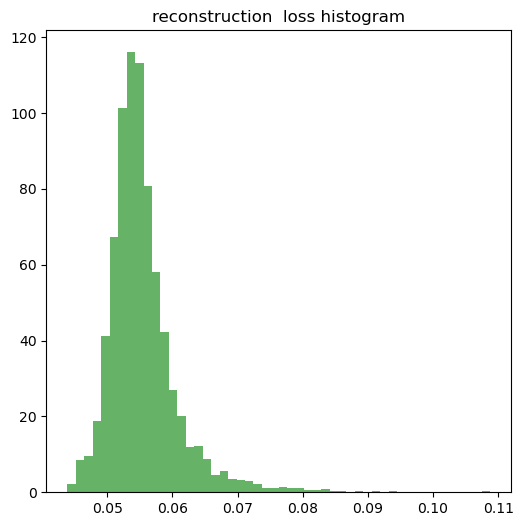

reconstruction threshold =  0.1087765246629715


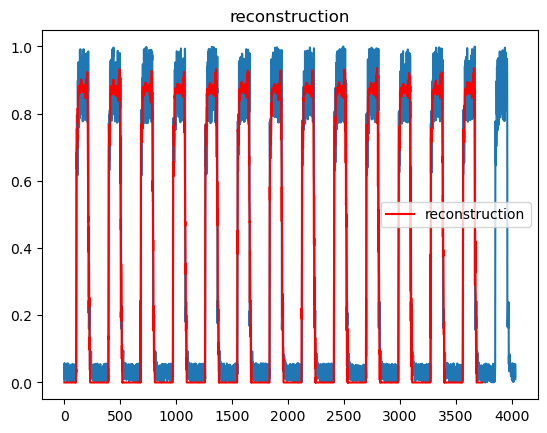

mae loss =  tensor([0.0610, 0.0658, 0.0611,  ..., 0.0541, 0.0548, 0.0599], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


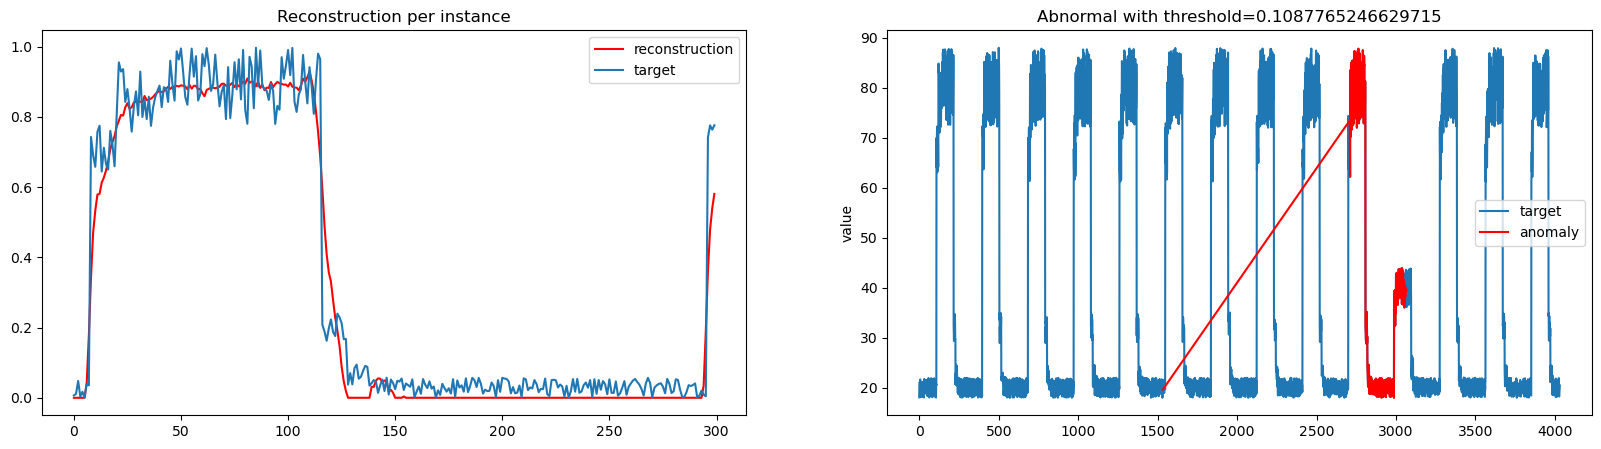

mae loss =  tensor([0.0598, 0.0565, 0.0644,  ..., 0.0567, 0.0550, 0.0539], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


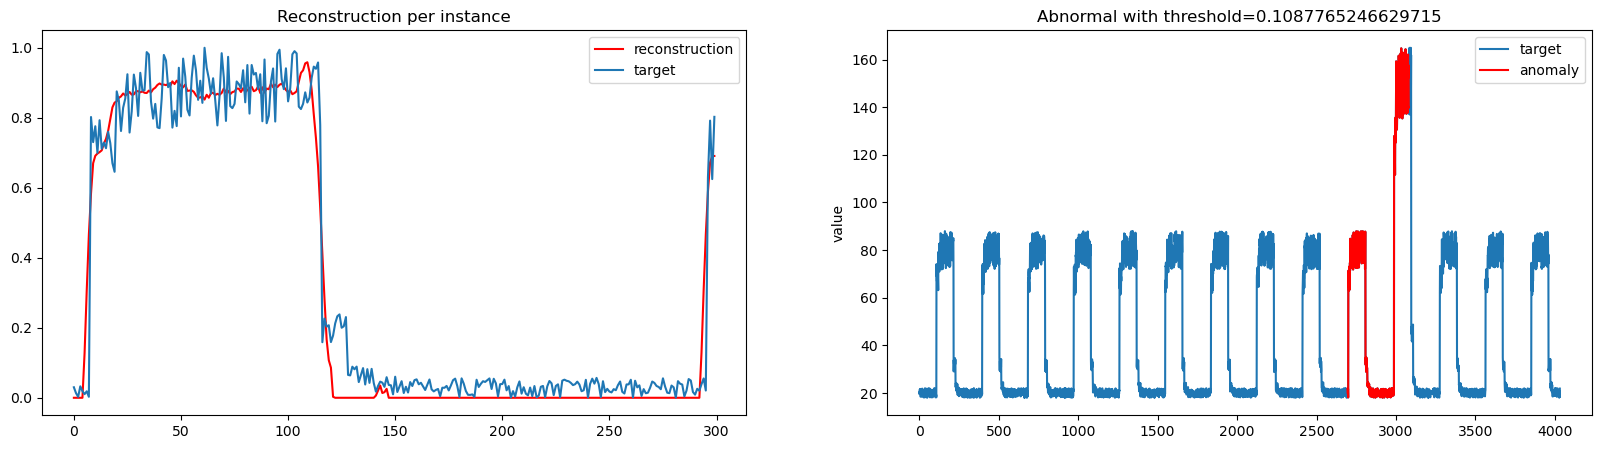

In [119]:
threshold = get_threshold(autoencoder, X_train, plot = True)
print('reconstruction threshold = ', threshold)
plot_reconstruction(autoencoder, train_df, TIME_STEP, scaler)

#evaluate
detect_anomaly(autoencoder, valid_df, TIME_STEP, scaler = scaler, threshold=threshold)
detect_anomaly(autoencoder, test_df, TIME_STEP,  scaler = scaler, threshold = threshold)

# Exp 2

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


array mean = 0.34930453425857083, max = 1.0, min = 0.0, std = 0.4012603985597367
array mean = 0.334757765626866, max = 1.0003180201807336, min = 1.5375989619259567e-05, std = 0.39239363825898665
array mean = 0.3808688941541068, max = 2.099981013951405, min = 6.545079308528656e-07, std = 0.4679912432337424


e = 4999, train loss = 0.012: 100%|██████████| 5000/5000 [04:29<00:00, 18.52it/s]


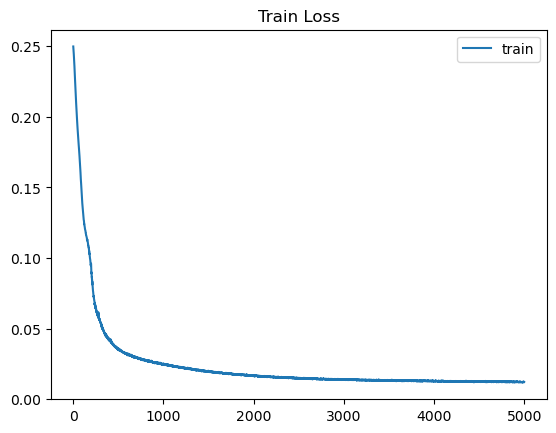

In [114]:
EMBEDDING_SIZE = 10
LR = 1e-3
TIME_STEP = 300
EXPERIMENT_NAME = 'v2'

scaler = MinMaxScaler()
test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

X_train = make_sequence(train_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_valid = make_sequence(valid_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_test = make_sequence(test_df, 'value',   time_step= TIME_STEP, scaler = scaler, debug = True)

X_train = X_train.float().to(DEVICE)
X_valid = X_valid.float().to(DEVICE)
X_test = X_test.float().to(DEVICE)

autoencoder = AutoencoderV2(input_size = TIME_STEP, hidden_size= EMBEDDING_SIZE, dropout = 0.2)

autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
autoencoder, history = tune(autoencoder, X_train, optimizer, criterion, epochs = 5000)

plot(history)

torch.save(autoencoder, f'autoencoder_{TIME_STEP}d.lstm.{EXPERIMENT_NAME}.torch')


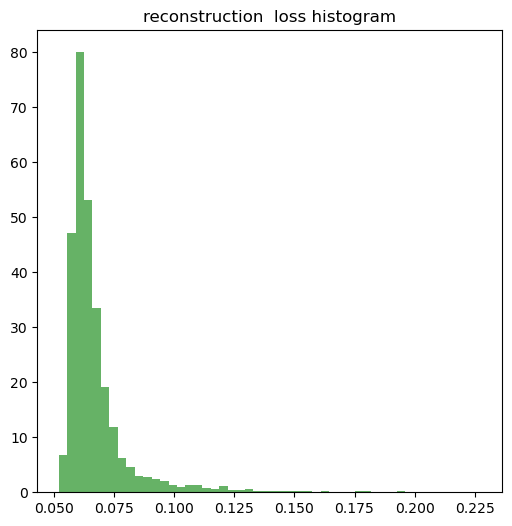

reconstruction threshold =  0.22768886387348175


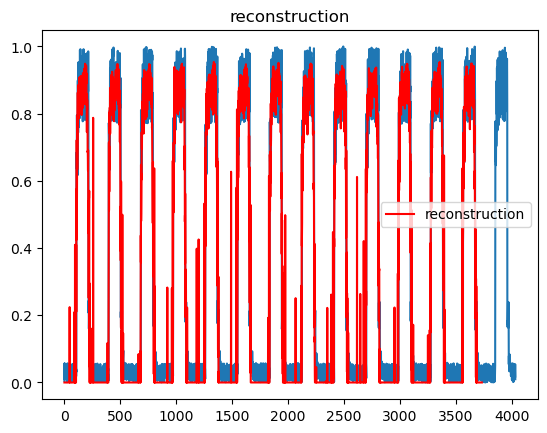

mae loss =  tensor([0.0696, 0.0815, 0.0670,  ..., 0.0616, 0.0668, 0.0629], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


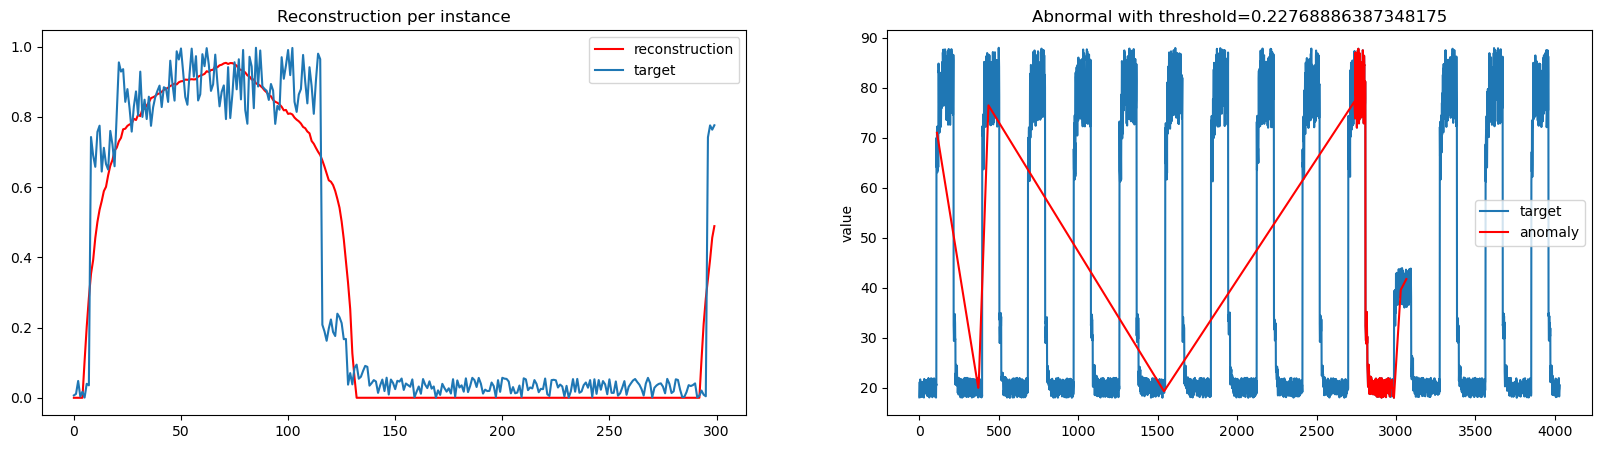

mae loss =  tensor([0.0712, 0.0813, 0.0656,  ..., 0.0693, 0.0601, 0.0616], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


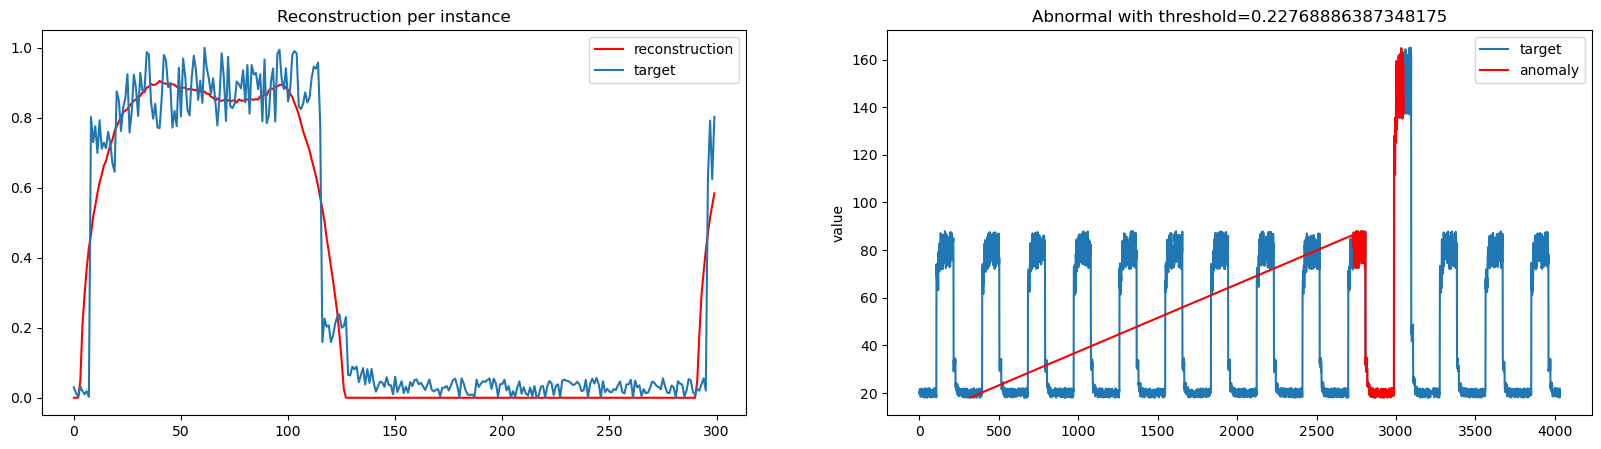

In [115]:
threshold = get_threshold(autoencoder, X_train, plot = True)
print('reconstruction threshold = ', threshold)
plot_reconstruction(autoencoder, train_df, TIME_STEP, scaler)

#evaluate
detect_anomaly(autoencoder, valid_df, TIME_STEP, scaler = scaler, threshold=threshold)
detect_anomaly(autoencoder, test_df, TIME_STEP,  scaler = scaler, threshold = threshold)


# Exp 3

array mean = 0.3562075109117898, max = 1.0, min = 0.0, std = 0.40286404712158896
array mean = 0.34261043131527047, max = 1.0003180201807336, min = 1.5375989619259567e-05, std = 0.3948631873593341
array mean = 0.38633823340171736, max = 2.099981013951405, min = 6.545079308528656e-07, std = 0.4658941200633877
X train =  torch.Size([3933, 100])
X valid =  torch.Size([3933, 100])
X test =  torch.Size([3933, 100])


  0%|          | 0/2000 [00:00<?, ?it/s]

e = 1999, train loss = 0.005: 100%|██████████| 2000/2000 [01:27<00:00, 22.81it/s]


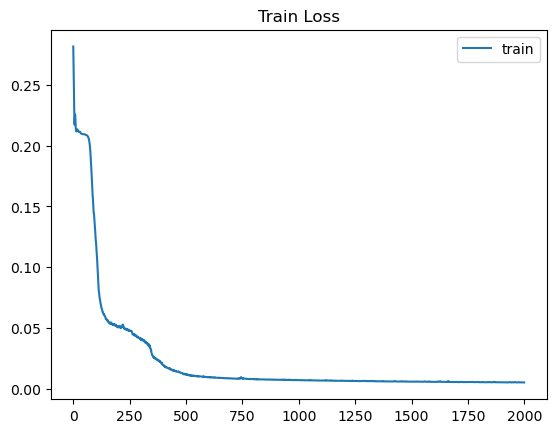

In [91]:
EMBEDDING_SIZE = 10
LR = 1e-3
TIME_STEP = 100
EXPERIMENT_NAME = 'v3'

# X_train = make_sequence(train_df, 'value', time_step=TIME_STEP)
# X_valid = make_sequence(valid_df, 'value', time_step=TIME_STEP)
# X_test = make_sequence(test_df, 'value', time_step=TIME_STEP)


scaler = MinMaxScaler()
test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

X_train = make_sequence(train_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_valid = make_sequence(valid_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_test = make_sequence(test_df, 'value',   time_step= TIME_STEP, scaler = scaler, debug = True)
print('X train = ', X_train.shape)
print('X valid = ', X_valid.shape)
print('X test = ', X_test.shape)

X_train = X_train.float().to(DEVICE)
X_valid = X_valid.float().to(DEVICE)
X_test = X_test.float().to(DEVICE)

autoencoder = Autoencoder(input_size = TIME_STEP, hidden_size= EMBEDDING_SIZE, dropout = 0.2)

autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
autoencoder, history = tune(autoencoder, X_train, optimizer, criterion, epochs = 2000)

plot(history)

torch.save(autoencoder, f'autoencoder_{TIME_STEP}d.lstm.{EXPERIMENT_NAME}.torch')


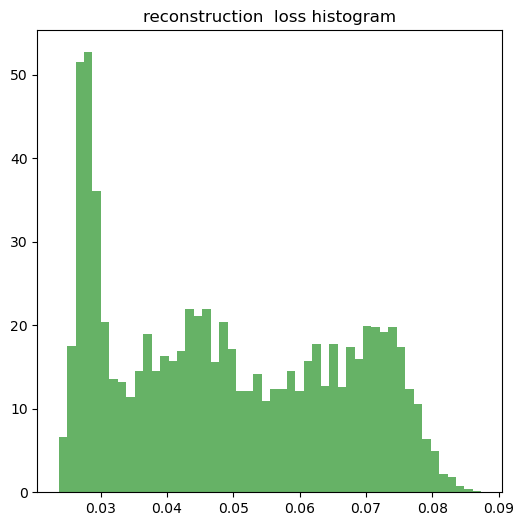

reconstruction threshold =  0.08738500624895096


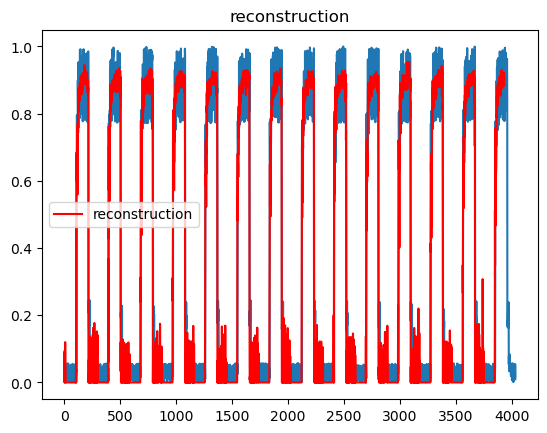

mae loss =  tensor([0.0294, 0.0294, 0.0300,  ..., 0.0553, 0.0541, 0.0545], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


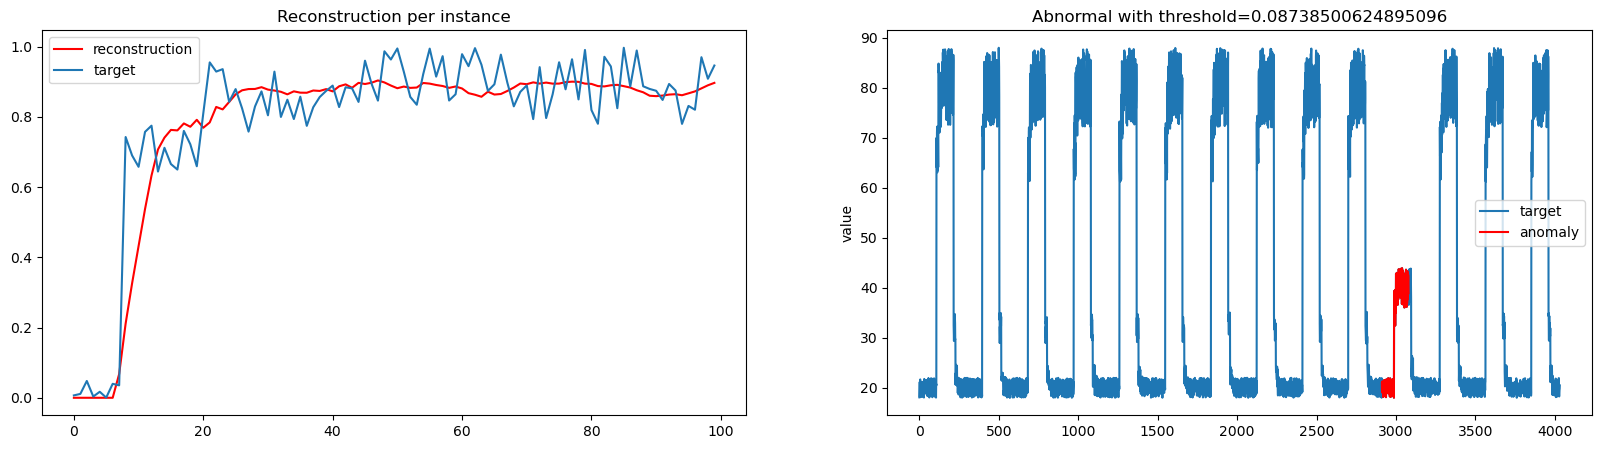

mae loss =  tensor([0.0292, 0.0296, 0.0304,  ..., 0.0541, 0.0541, 0.0532], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


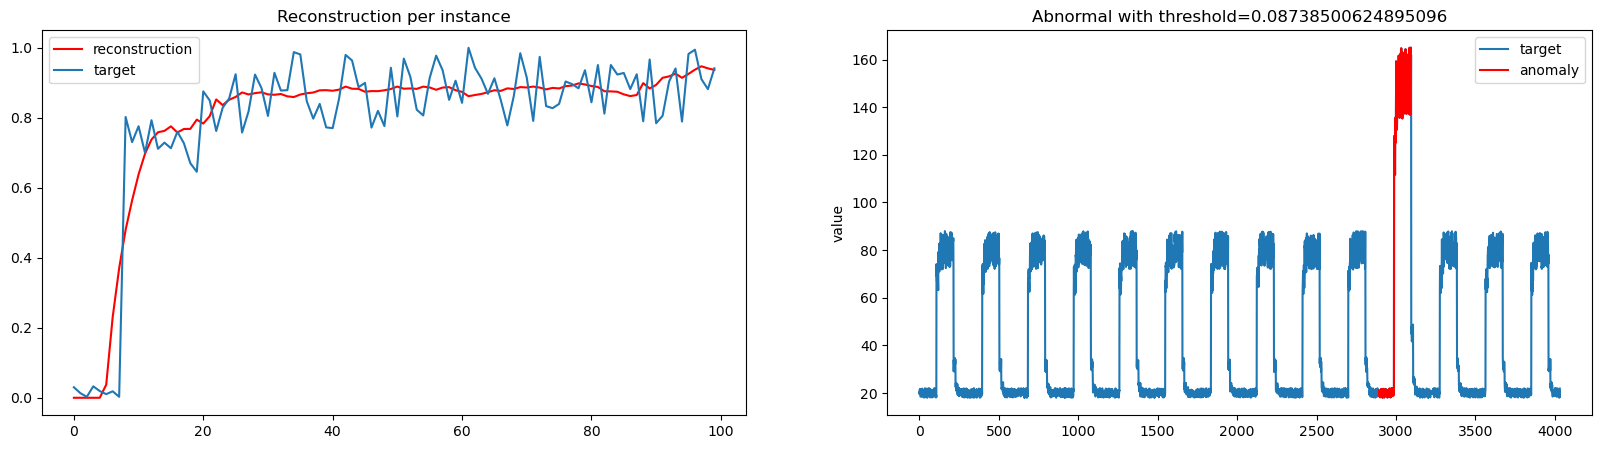

In [113]:
threshold = get_threshold(autoencoder, X_train, plot = True)
print('reconstruction threshold = ', threshold)
plot_reconstruction(autoencoder, train_df, TIME_STEP, scaler)

#evaluate
detect_anomaly(autoencoder, valid_df, TIME_STEP, scaler = scaler, threshold=threshold)
detect_anomaly(autoencoder, test_df, TIME_STEP,  scaler = scaler, threshold = threshold)

# Observation

After many trials, we conclude that linear layer can somewhat resemble the original data, but not very accurate. It can tell the location of anomaly like in previous valid and test plot reconstruction. But it's a little a ahead of the actual anomaly. 